### Run vanilla `scarlet` for ~5476 LSBG candidates at 0.02 < z < 0.04.

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [4]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/tigress/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [6]:
lsbg_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')
print('# of LSBGs:', len(lsbg_cat))

# of LSBGs: 5576


In [8]:
# Imcomplete file
np.array([  462,  4081,  6161,  8176,  7406,  9498, 12637, 38550,
       40895, 38890, 36497, 42403, 47032, 48071, 48284,
       48689, 61669, 59005, 60514, 63338, 62688, 83009,
       84001, 87524, 88927, 85773, 88419, 89528]).shape
# real_fail: 46202, 84988

(28,)

In [13]:
lsbg = lsbg_cat[int(np.where(lsbg_cat['viz-id'] == 40671)[0][0])]

### Running scarlet wavelet modeling for `/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/NSA/nsa_40671`
    Working directory: /tigress/jiaxuanl/Data/HSC/LSBG
  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    5 stars from Gaia are masked!
    Detected 126 objects
    5 stars from Gaia are masked!
    Detected 104 objects
    Detected 58 objects
  - Wavelet modeling with the following hyperparameters:
    min_grad = -0.10, starlet_thresh = 1.00 (contam_ratio = 0.07).
    Total number of sources: 19
    Optimizaiton: Succeed for e_rel = 0.0001 with 64 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 104 iterations! Try higher accuracy!
  - After 84 iterations, logL = 1001369.80
    Elapsed time for fitting: 76.07 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /tigress/jiaxuanl/Data/

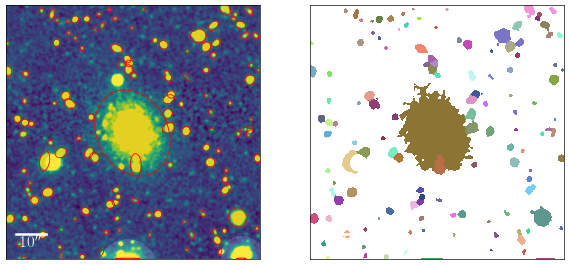

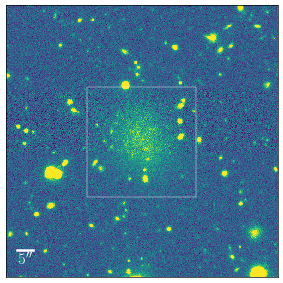

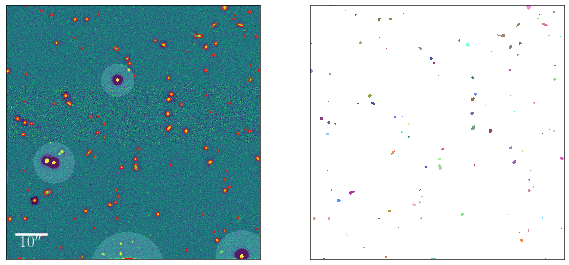

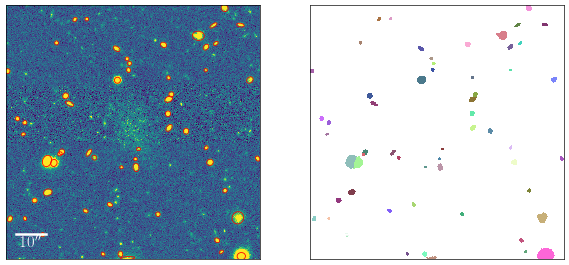

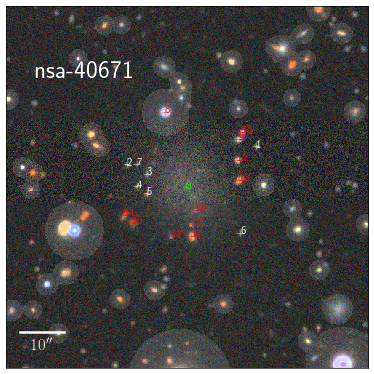

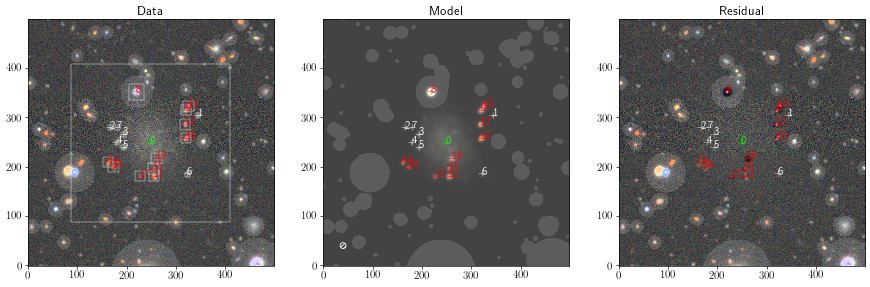

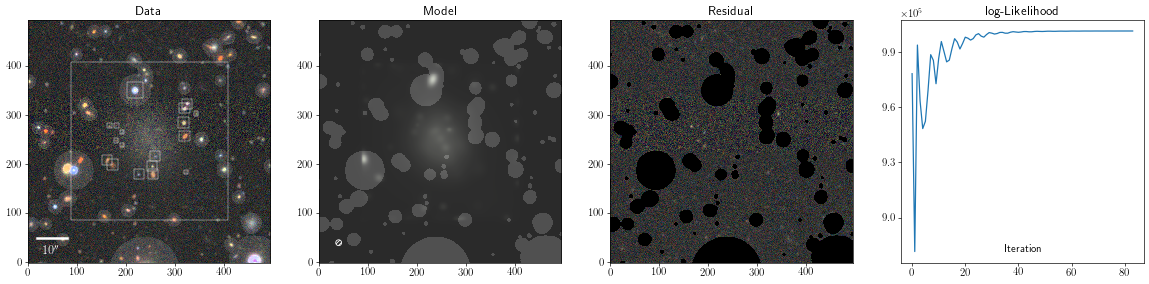

In [14]:
fitting_obs_tigress(env_dict,
                    lsbg,
                    name='viz-id',
                    method='wavelet', 
                    starlet_thresh=1,
                    prefix='nsa', 
                    model_dir='./Model/nsa_z002_004/',
                    figure_dir='./Figure/nsa_z002_004/',
                    log_dir='./log/nsa_z002_004/',
                    show_figure=True)

In [98]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [99]:
fitter = ScarletFitter(method='vanilla', tigress=True, starlet_thresh=0.5,
                       log_dir='./log/', 
                       figure_dir='./Figure/',
                       model_dir='./Model/',
                       prefix='test', index=0, show_figure=True)
fitter.load_data(data, lsbg_coord)

#### Step-by-step

In [100]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    5 stars from Gaia are masked!


In [101]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 155 objects


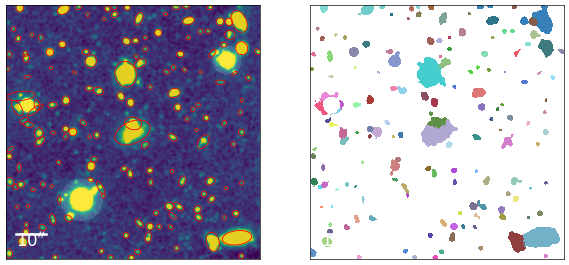

In [102]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.006

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.02
        
fitter._first_detection(first_dblend_cont)

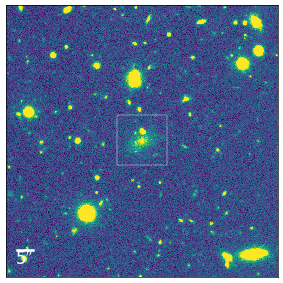

In [103]:
fitter._estimate_box(fitter.cen_obj)

In [104]:
fitter._mask_stars_outside_box()

    5 stars from Gaia are masked!


    Detected 119 objects


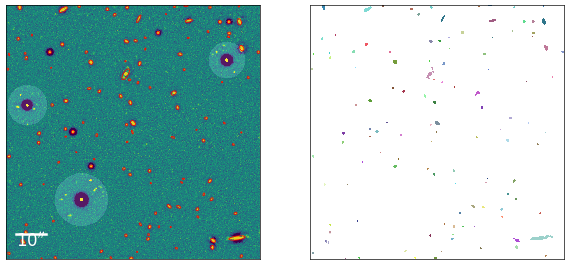

In [105]:
fitter._cpct_obj_detection()

    Detected 62 objects


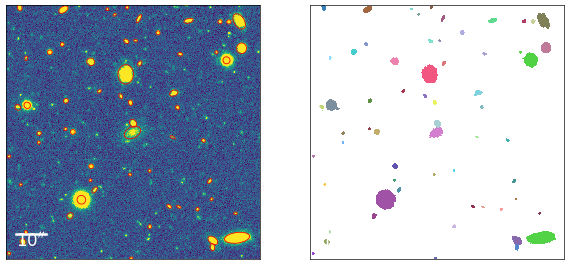

In [119]:
fitter._big_obj_detection()

In [120]:
fitter._merge_catalogs()

In [121]:
fitter._construct_obs_frames()

In [122]:
import sep

In [123]:
conv_data = np.zeros_like(fitter.data.images)
for i in range(len(fitter.data.images)):
    input_data = convolve(
        fitter.data.images[i].astype(float), Gaussian2DKernel(1.5))
    # input_data = fitter.data.images[i].astype(float)
    bkg = sep.Background(input_data, bw=50, bh=50, fw=3.5, fh=3.5)
    input_data -= bkg.back()
    conv_data[i] = input_data

In [124]:
observation = scarlet.Observation(
    conv_data,
    wcs=fitter.data.wcs,
    psf=fitter.data.psfs,
    weights=fitter.data.weights,
    channels=list(fitter.data.channels))
fitter._conv_observation = observation.match(fitter.model_frame)

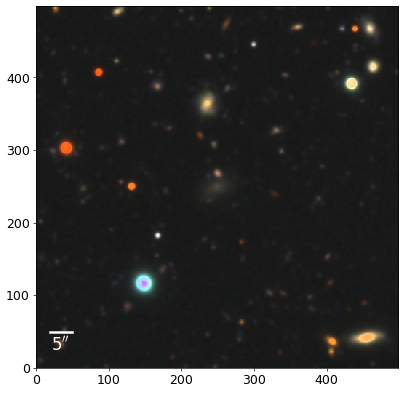

In [125]:
display_rgb(conv_data);

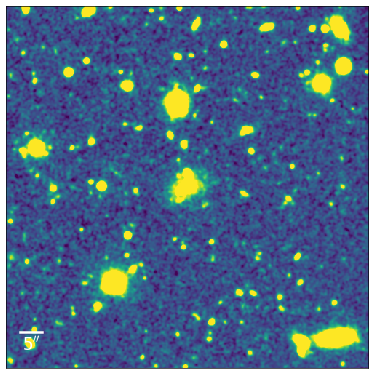

In [126]:
display_single(conv_data[2]);

In [127]:
# display_rgb(conv_data);

In [128]:
fitter._add_central_source(min_grad=-0.1, thresh=0.01)[0].bbox

<Box shape=(4, 101, 101), origin=(0, 201, 199)>

In [129]:
fitter._add_sources(min_grad=-0.1, thresh=.01)

    Total number of sources: 4


[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

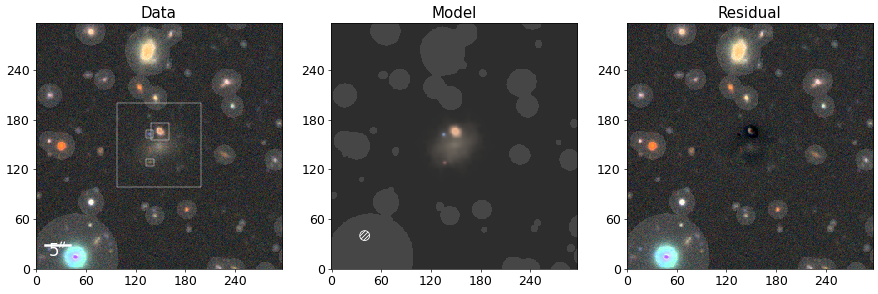

In [130]:
kz.display.display_scarlet_model(
    fitter.blend,
    #show_ind=[0],
    zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

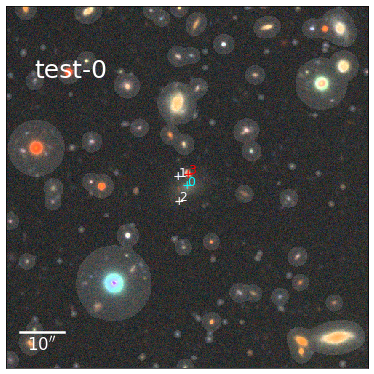

In [131]:
fig = kz.display.display_scarlet_sources(
        fitter.data,
        fitter._sources,
        show_ind=None,
        stretch=1,
        Q=1,
        minimum=-0.3,
        show_mark=True,
        scale_bar_length=10,
        add_text=f'{fitter.prefix}-{fitter.index}')

    Optimizaiton: Succeed for e_rel = 0.0001 with 44 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 84 iterations! Try higher accuracy!
  - After 38 iterations, logL = 1120592.00
    Elapsed time for fitting: 22.64 s


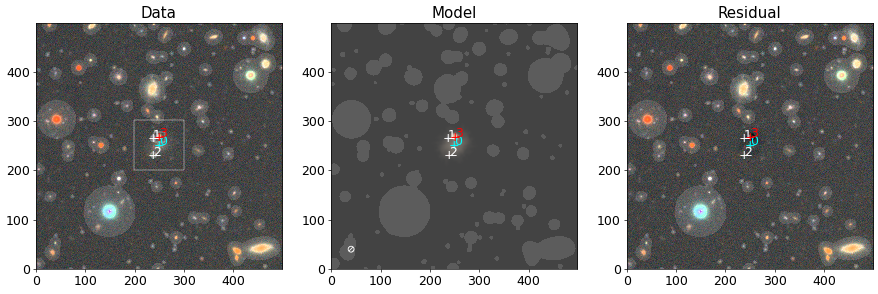

In [132]:
fitter._optimize()

In [133]:
fitter._find_sed_ind()

  - Components [0] are considered as the target galaxy.


In [134]:
fitter._gen_final_mask()

  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /tigress/jiaxuanl/Data/HSC/LSBG/Model/test-0-trained-model-vanilla.df


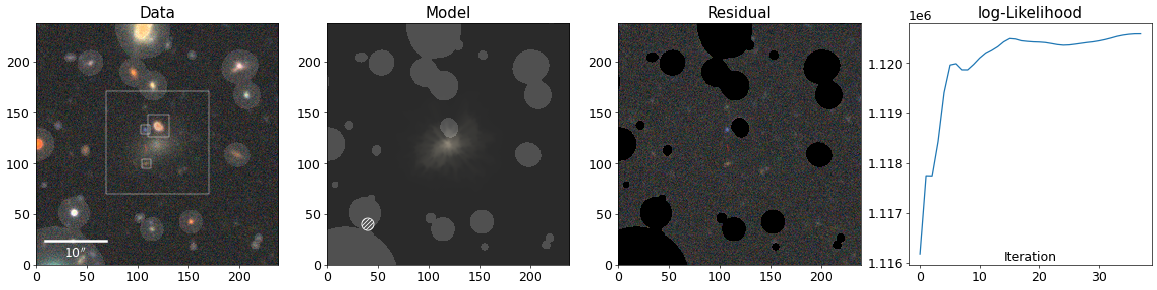

In [135]:
fitter._display_results()

In [136]:
from kuaizi.measure import makeMeasurement

In [137]:
measurement, _ = makeMeasurement(list(np.array(fitter.blend.sources)[[0]]),
                                 fitter.blend.observations[0],
                                 aggr_mask=None, #mask.astype(bool),
                                 makesegmap=False, sigma=1,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=False, asinh_a=0.02, framealpha=0.7)

In [140]:
measurement['mag']

array([21.722782, 21.107222, 20.747671, 20.612709], dtype=float32)

In [139]:
measurement['rhalf_circularized'] * 0.168

2.7025816145873387